# last updated 4/4/2020
+ I'm seeing a drop of rate of growth across the states, especially in NY, indicating "safe at home" is having some effects. The states without agressive containment such as TX is showing higher growth rate <BR>
<BR>
+ It is a very simple model to track the progress of Covid in major countries and estimate if the exponential (explosive) spread of the virus is slowing down 
+ I fit the data to an exponential function N=I x exp(Ke*days). And by looking at the data fit of (1) all data; (2) the most recent 5-7 day data; (3) and setdiff([1],[2]) and examining how Ke (the constant in the exponent) changes, we can compare the "explosiveness" of the spread in different regions (the higher Ke, the faster the spread) and estimate if the spread is slowing down (significant drop in Ke)
+ 3/28: I added a "range" of estimate to account for change in the rate of growth based on last 7 days of data. This is kind of ad-hoc, mostly used to highlight the uncertainty in the prediction. A very tight range indicates the trend is a very good exponential fitting and the prediction is likely to be accurate.
+ 3/28: I also added the data for a few large states in the US

#### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

#### Define the fitting function, which is a simple expoential function -- what really matters is the exponent constant

In [2]:
def func(x, I0, k):     # a = I0, b = k
  return I0 * np.exp(k*(x-x[0]))    
  #return I0 * np.exp(k*x)    

#### Setup Analysis parameters, Import the data and seperate into more recent and "old" ones

In [3]:
start={
       "China" : "2020-01-22",
       "Spain" : "2020-03-01",
       "Italy" : "2020-02-22",
       "Canada": "2020-02-26",
       "US-ALL": "2020-03-01",
       "US-NY": "2020-03-01", 
       "US-CA": "2020-03-01",
       "US-WA": "2020-03-01",
       "US-MA": "2020-03-01",
       "US-IL": "2020-03-01",
       "US-TX": "2020-03-01"
}
Nback  = 7-2 # use a number of days to check if trend has changed
Nfwd   = 7

# import and print out data
df = pd.read_csv('data.csv',delim_whitespace=True, parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])
dNow   = datetime.now() - timedelta(days=1)            # today
print ('Tablulated Positive Covid-19 Cases for countries of interest')
display(HTML(df.loc[df['Date']<dNow,:].to_html(index=False,float_format="%d",border=2)))

Tablulated Positive Covid-19 Cases for countries of interest


Date,China,Italy,Spain,Canada,US-ALL,US-NY,US-CA,US-WA,US-MA,US-TX,US-IL
2020-01-22,571,0,0,0,0,0,0,0,0,0,0
2020-01-23,830,0,0,0,0,0,0,0,0,0,0
2020-01-24,1287,0,0,0,0,0,0,0,0,0,0
2020-01-25,1975,0,0,0,0,0,0,0,0,0,0
2020-01-26,2744,0,0,0,0,0,0,0,0,0,0
2020-01-27,4515,0,0,0,0,0,0,0,0,0,0
2020-01-28,5974,0,0,0,0,0,0,0,0,0,0
2020-01-29,7711,0,0,0,0,0,0,0,0,0,0
2020-01-30,9692,0,0,0,0,0,0,0,0,0,0
2020-01-31,11791,0,0,0,0,0,0,0,0,0,0


#### function to analyze one country's data 

In [4]:
def analyze_case(country):
    # seperate into different segment
    if country=="China": 
        dEnd = pd.to_datetime("2020-02-12")  # china starts early and ends early
    else:
        dEnd = dNow
    dTurn1 = dEnd - timedelta(days=Nback+1)      # go bkwd to seperate old from recent 
    dTurn2 = dEnd - timedelta(days=Nback+2)
    dFwd   = dEnd + timedelta(days=Nfwd-1)       # go a few days fwd for prediction
    dStart = pd.to_datetime(start[country])                   # each country start to have cases accelerating at differnt time
    
    df0 = df.loc[(df.Date>dStart)  & (df.Date<dEnd) ,:]       # all data to be analyzed
    df1 = df.loc[(df.Date>dStart)  & (df.Date<dTurn1) ,:]     # "old" data
    df2 = df.loc[(df.Date>=dTurn2) & (df.Date<dEnd),:]       # recent data
    df3 = df.loc[(df.Date>dStart)  & (df.Date<dFwd) ,:]      # forcast
    my_xticks = df3["Date"].dt.strftime("%b%d")
    
    # optimal data fitting for each segment
    y0 = df0[country]
    y1 = df1[country]
    y2 = df2[country]
    x0 = np.arange(1,len(y0)+1)
    x1 = np.arange(1,len(y1)+1)
    x2 = np.arange(len(y0)-len(y2)+1,len(y0)+1)
    x3 = np.arange(len(y0),len(y0)+Nfwd+1)
    popt0, pcov = curve_fit(func, x0, y0)
    popt1, pcov = curve_fit(func, x1, y1)
    popt2, pcov = curve_fit(func, x2, y2)
    
    # print out summary of results
    print ("Exponent Values:")
    print ("  all data     = %.3f" % popt0[1])
    print ("  old data     = %.3f" % popt1[1]) 
    print ("  recent data  = %.3f" % popt2[1])
    title_txt = r': $N_{all} = I_{all}'+'*e^{('+f'{popt0[1]:.3f}'+'*days)}$;  ' + r'$N_{past} = I_{past}'+'*e^{('+f'{popt1[1]:.3f}'+'*days)}$' + r';   $N_{latest} = I_{latest}'+'*e^{('+f'{popt2[1]:.3f}'+'*days)}$'
    
    v1 = func(x1, *popt1) 
    v2 = func(x2, *popt2)    
    vF1 = func(x3, *popt2)
    vF1 *= v2[-1]/vF1[0]
    # popt2[1] -=  np.max((popt0[1]-popt2[1]),0)*7.0/len(x1)
    popt2[1] -=  (popt1[1]-popt2[1])/3.
    vF2 = func(x3, *popt2)
    vF2 *= v2[-1]/vF2[0]
    
    print ("predicted cases at the end of next %d days is [%.1f-%.1f]k" % (Nfwd,vF2[-1]/1000,vF1[-1]/1000))
    
    # plot results    
    fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(x0, func(x0, *popt0), 'b--', label="all fit")  
    plt.plot(x1, y1, 'bo',label="past data")
    plt.plot(x1, v1, 'b', label="past fit")  
    plt.plot(x2, y2, 'md',label="recent data")
    plt.plot(x2, v2, 'm', label="recent fit") 
    plt.plot(x3[1:], vF1[1:], 'rv--', label="Forcast Based on Latest Fit ") 
    plt.plot(x3[1:], vF2[1:], 'r^--', label="Forcast Based on Adjusted Fit") 
    plt.xticks(np.append(x0,x3),my_xticks, rotation='vertical')
    plt.ylabel('# of cases')
    plt.title(country + title_txt,fontsize=16, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.show()

### 中国（到二月中）

Exponent Values:
  all data     = 0.126
  old data     = 0.197
  recent data  = 0.075
predicted cases at the end of next 7 days is [58.1-77.2]k


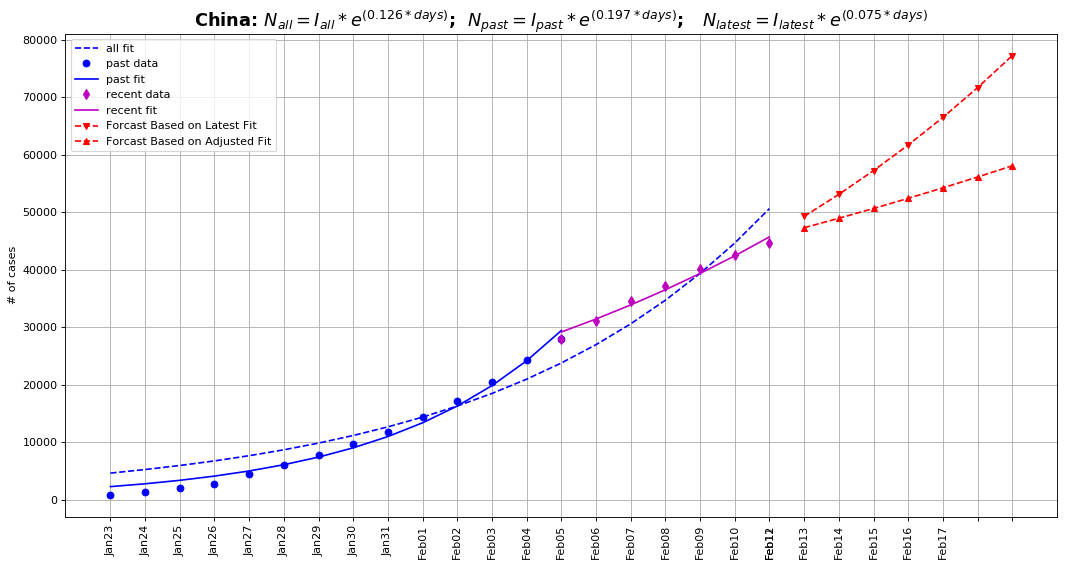

In [5]:
analyze_case("China")

### 意大利

Exponent Values:
  all data     = 0.081
  old data     = 0.106
  recent data  = 0.041
predicted cases at the end of next 7 days is [142.7-166.0]k


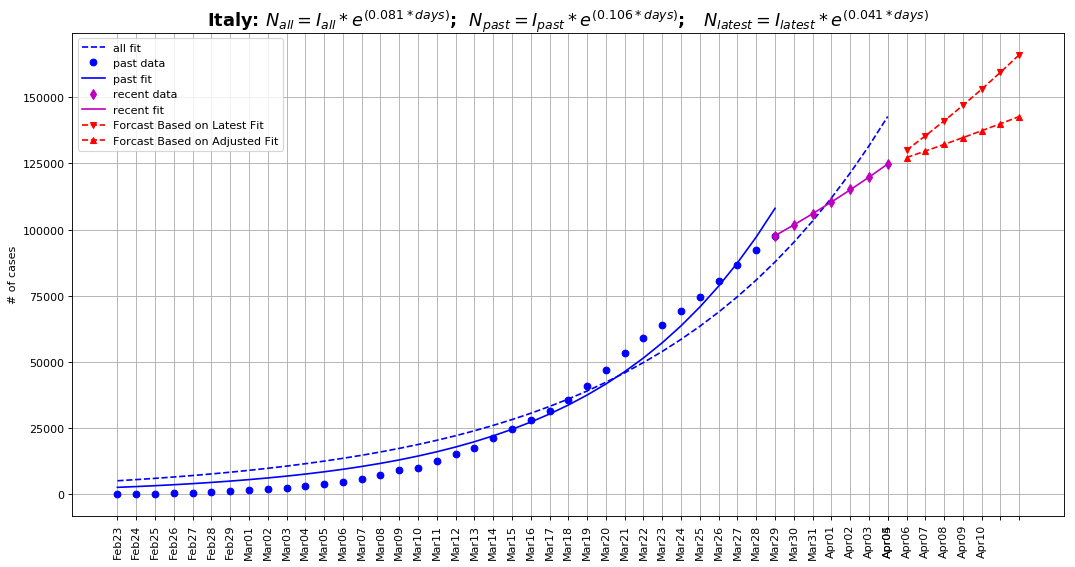

In [6]:
analyze_case("Italy")

### 西班牙

Exponent Values:
  all data     = 0.115
  old data     = 0.157
  recent data  = 0.074
predicted cases at the end of next 7 days is [177.5-215.3]k


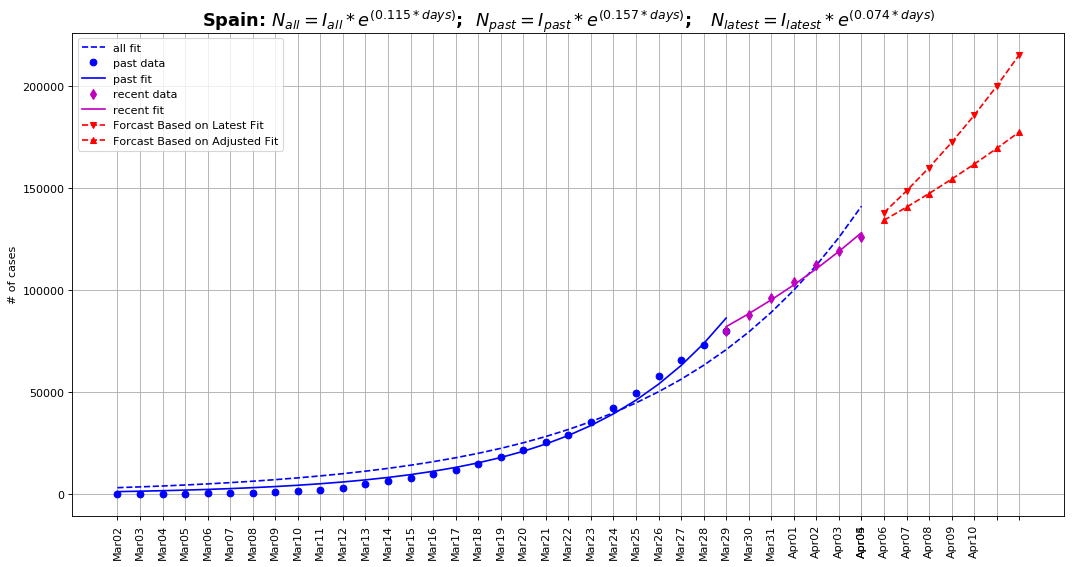

In [7]:
analyze_case("Spain")

### 加拿大

Exponent Values:
  all data     = 0.151
  old data     = 0.193
  recent data  = 0.127
predicted cases at the end of next 7 days is [29.3-34.2]k


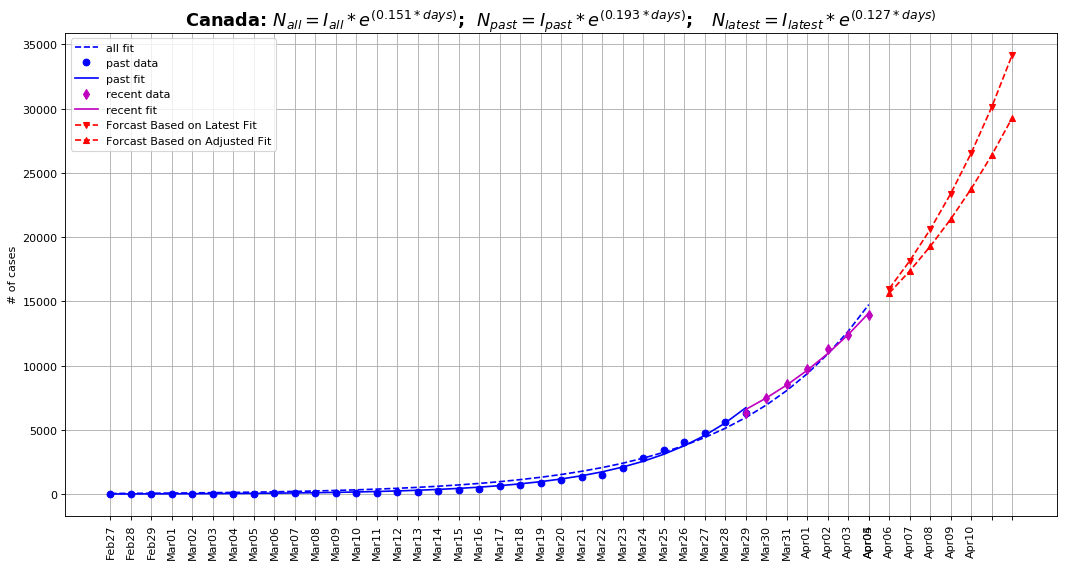

In [8]:
analyze_case("Canada")

### 美国（全国）

Exponent Values:
  all data     = 0.157
  old data     = 0.216
  recent data  = 0.128
predicted cases at the end of next 7 days is [627.9-770.1]k


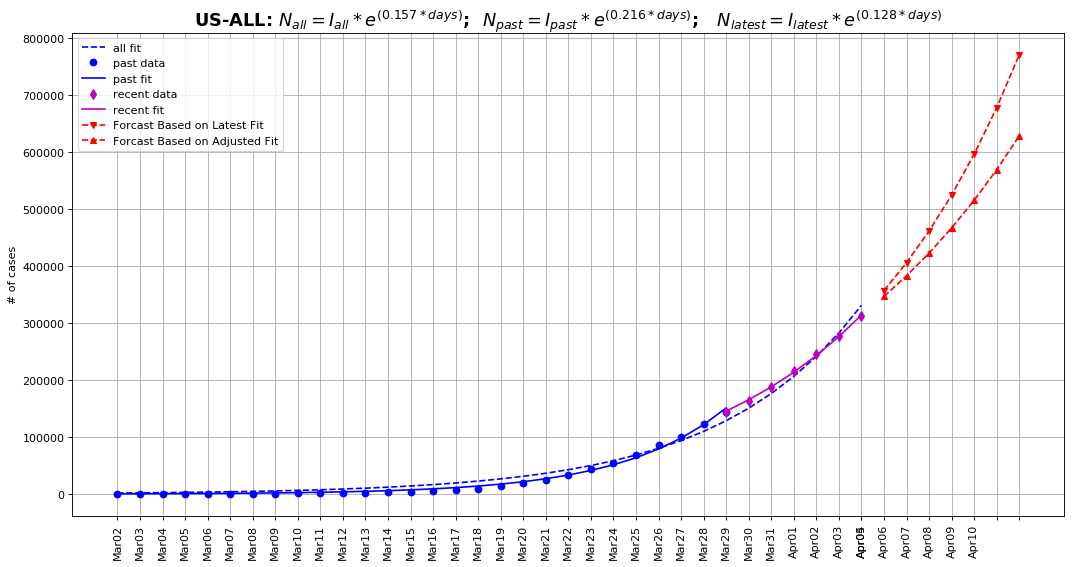

In [9]:
analyze_case("US-ALL")

### 美国-纽约

Exponent Values:
  all data     = 0.142
  old data     = 0.203
  recent data  = 0.107
predicted cases at the end of next 7 days is [193.4-242.5]k


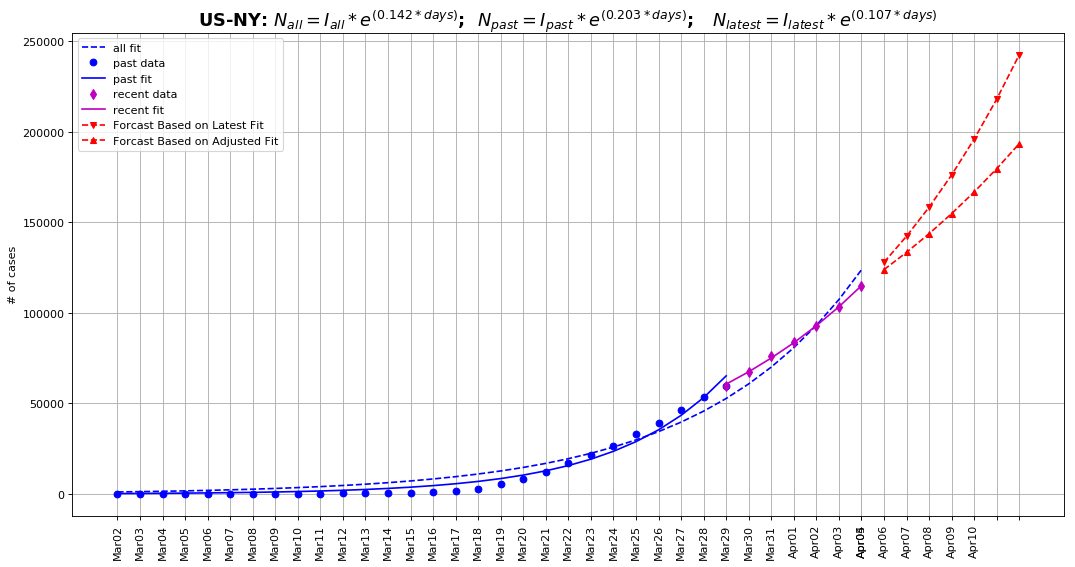

In [10]:
analyze_case("US-NY")

### 美国-加州

Exponent Values:
  all data     = 0.149
  old data     = 0.182
  recent data  = 0.128
predicted cases at the end of next 7 days is [30.5-34.6]k


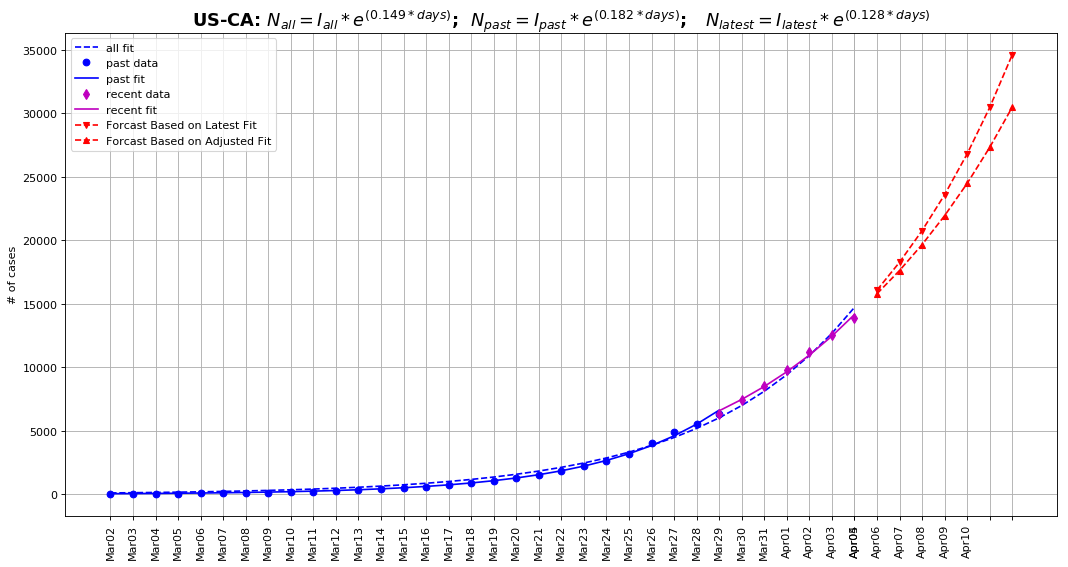

In [11]:
analyze_case("US-CA")

### 美国-麻州

Exponent Values:
  all data     = 0.177
  old data     = 0.272
  recent data  = 0.144
predicted cases at the end of next 7 days is [24.1-32.5]k


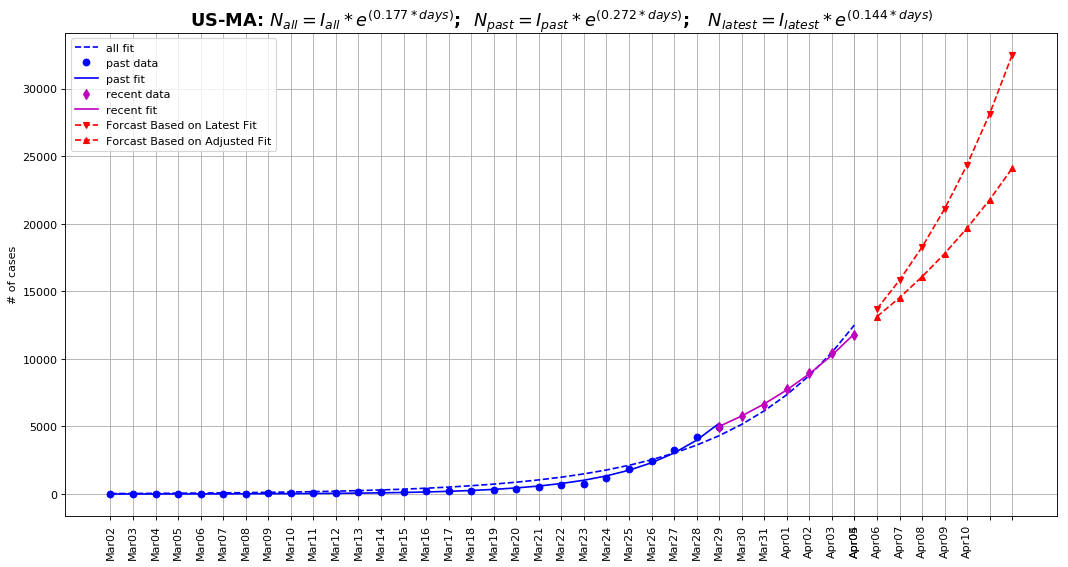

In [12]:
analyze_case("US-MA")

### 美国-德州

Exponent Values:
  all data     = 0.167
  old data     = 0.214
  recent data  = 0.153
predicted cases at the end of next 7 days is [17.5-20.2]k


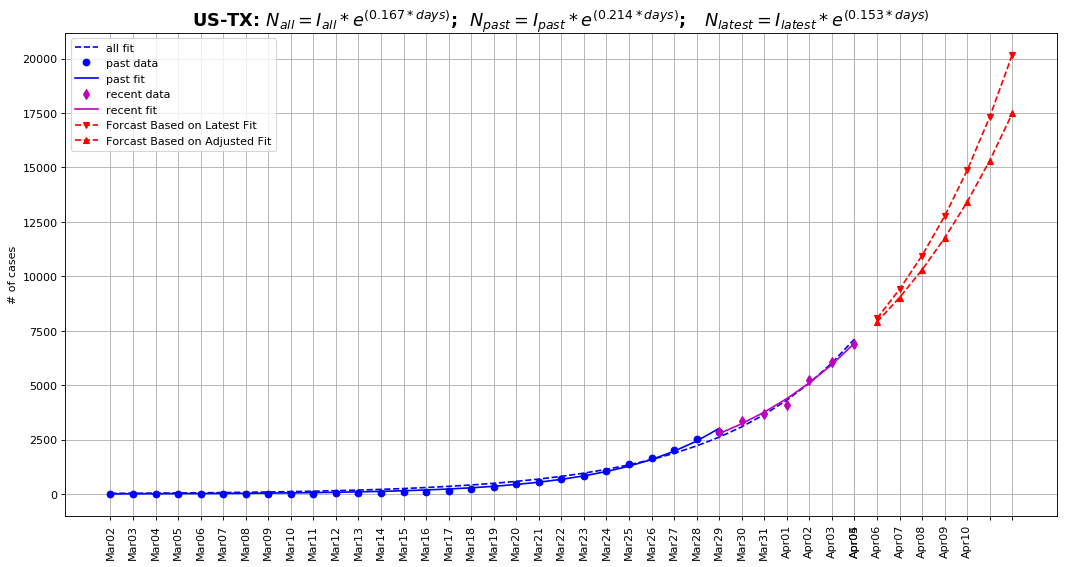

In [13]:
analyze_case("US-TX")

### 美国-伊里诺伊

Exponent Values:
  all data     = 0.166
  old data     = 0.226
  recent data  = 0.137
predicted cases at the end of next 7 days is [21.8-26.9]k


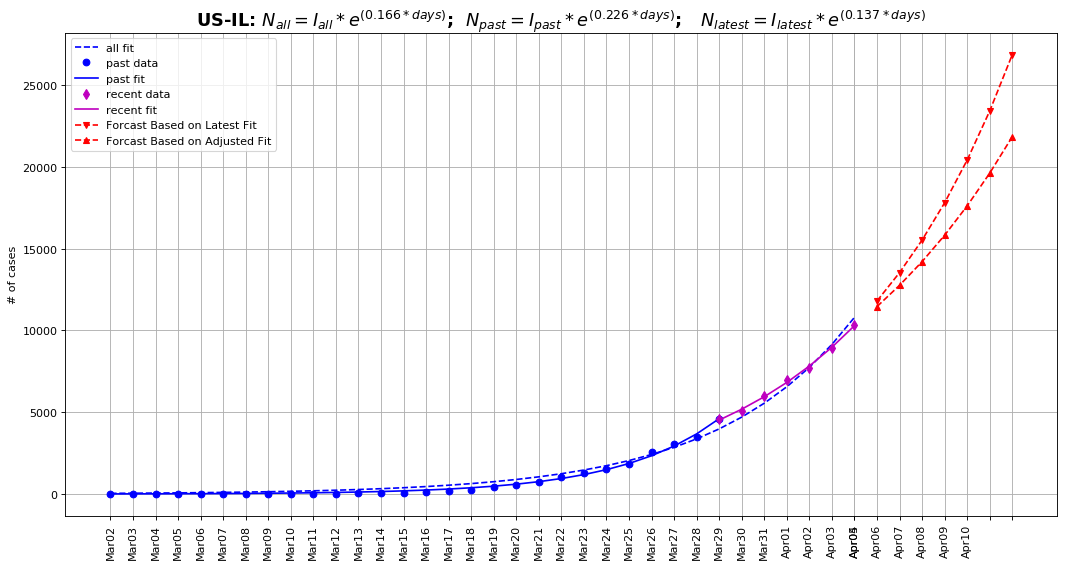

In [14]:
analyze_case("US-IL")

### 美国-华盛顿州

Exponent Values:
  all data     = 0.111
  old data     = 0.143
  recent data  = 0.077
predicted cases at the end of next 7 days is [11.1-12.9]k


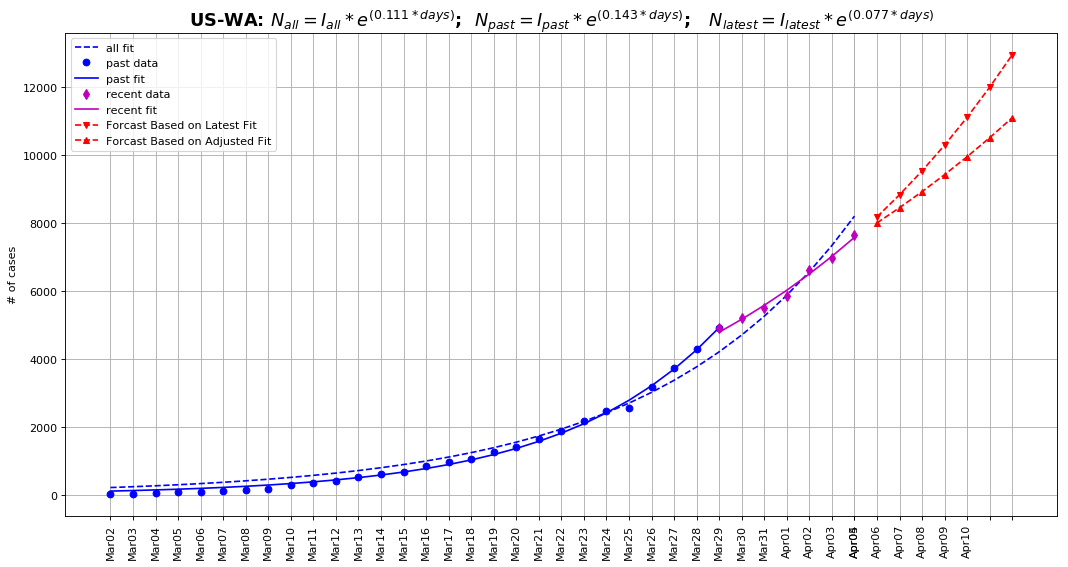

In [15]:
analyze_case("US-WA")